<a href="https://colab.research.google.com/github/ebceran/Fraud-Detection-XGBoost-/blob/main/fraud_detection_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import xgboost as xgb
import shap

In [15]:
import pandas as pd
import numpy as np

np.random.seed(42)

n = 50000

df = pd.DataFrame({
    "amount": np.random.gamma(4, 200, n),
    "oldbalanceOrg": np.random.uniform(0, 50000, n),
    "newbalanceOrig": np.random.uniform(0, 50000, n),
    "oldbalanceDest": np.random.uniform(0, 50000, n),
    "newbalanceDest": np.random.uniform(0, 50000, n),
    "transaction_type": np.random.choice(["TRANSFER", "CASH_OUT"], n, p=[0.6, 0.4])
})

# Fraud mask — broader conditions
fraud_mask = (
    (df["transaction_type"] == "TRANSFER") &
    (df["amount"] > 2000) &
    (df["oldbalanceOrg"] < df["amount"] * 0.5)
)

# Number of frauds: guaranteed to be at least 800–1200
fraud_indices = fraud_mask.sample(frac=0.2, random_state=42).index

df["isFraud"] = 0
df.loc[fraud_indices, "isFraud"] = 1

print("Fraud count:", df['isFraud'].sum())
print("Fraud ratio:", df['isFraud'].mean())

df.to_csv("fraud.csv", index=False)


Fraud count: 10000
Fraud ratio: 0.2


In [17]:
df = pd.read_csv("fraud.csv")
df["isFraud"].value_counts(normalize=True)

,proportion
isFraud,
0,0.8
1,0.2


In [18]:
df = pd.get_dummies(df, columns=["transaction_type"], drop_first=True)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transaction_type_TRANSFER
0,940.482780,37020.864871,47493.861556,821.728384,13454.761402,0,True
1,681.646380,44881.160237,21307.652982,44586.535116,48908.786601,0,False
2,647.264942,2791.396333,22156.982476,2272.437765,35916.497378,0,False
3,647.270727,20530.375870,11666.784600,41533.496894,33142.312539,0,True
4,1519.622023,20418.302222,26084.198622,42114.700608,24256.702584,1,False


In [20]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

# 0 → %99.4
# 1 → %0.6

((40000, 6), (10000, 6))

In [23]:
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
scale_pos_weight

4.0

In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [26]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.5034109062500001
              precision    recall  f1-score   support

           0       0.80      0.63      0.71      8000
           1       0.20      0.36      0.26      2000

    accuracy                           0.58     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.68      0.58      0.62     10000



In [27]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[5068, 2932],
       [1274,  726]])

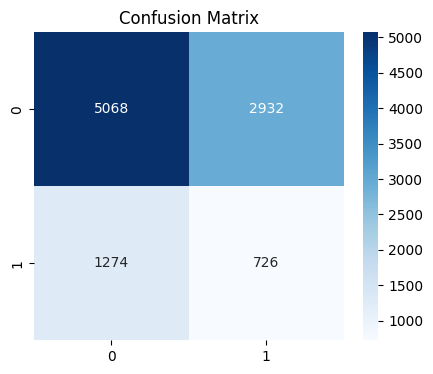

In [28]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

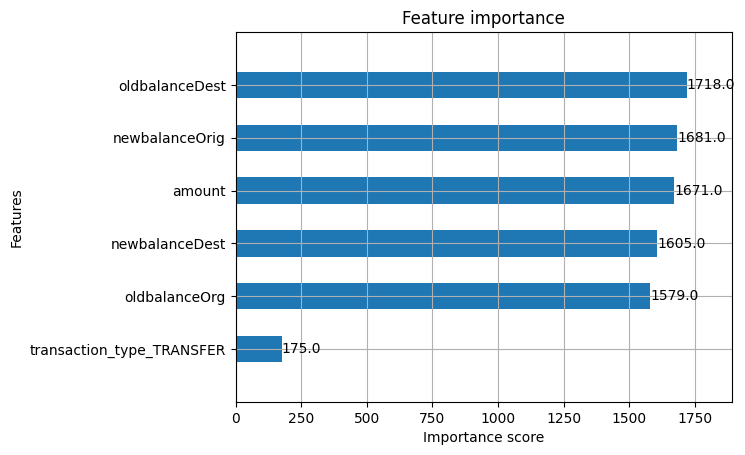

In [29]:
xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.show()

In [30]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

/tmp/ipython-input-2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


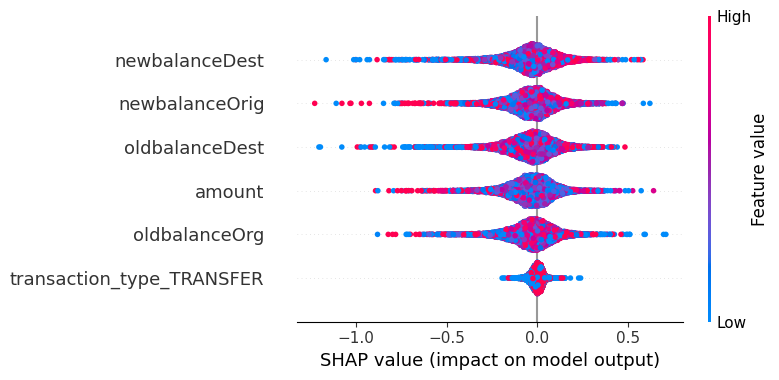

In [31]:
shap.summary_plot(shap_values, X_test)

/tmp/ipython-input-3237810805.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


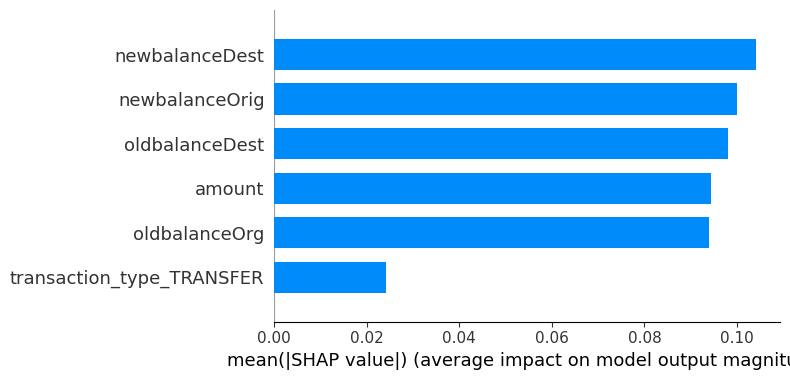

In [32]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

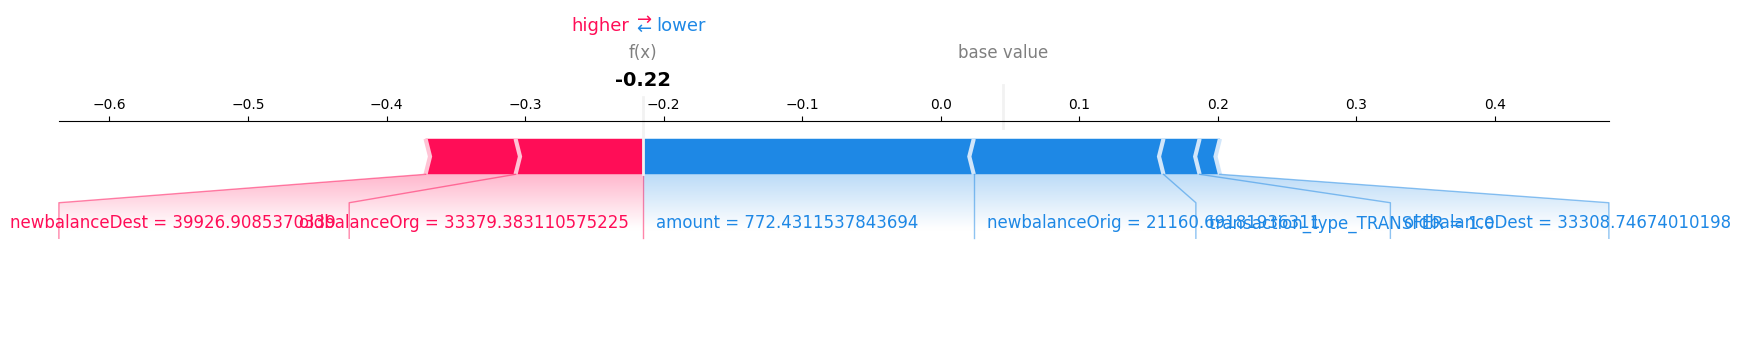

In [33]:
i = 0   # ilk test örneği
shap.force_plot(explainer.expected_value,
                 shap_values[i, :],
                 X_test.iloc[i, :],
                 matplotlib=True)

In [34]:
from google.colab import files
files.download("fraud.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>